In [ ]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import tf

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



$u_t + v u_x = q(x, t), \ x \in \mathbb{R}, \ t \geq 0$ \\
$u(x, 0) = 0, \ x \in \mathbb{R}$

The $q(x, t)$ function is treated as the unknown of this inverse problem; while its true value is:

$q(x, t) = t \sin(x)$

with this value of $q$ the analytical solution of the PDE is

$u(x, t) = - \frac{t}{v} \cos(x) + \frac{1}{v^2} (\sin(x) - \sin(x - v t))$

In [ ]:
v = 3
L = 4
T = 1

In [ ]:
def exact_q(x):
  return x[:, 1:2] * np.sin(x[:, 0:1])

def exact_u(x):
  return - (x[:, 1:2] / v) * np.cos(x[:, 0:1]) + ((np.sin(x[:, 0:1]) - np.sin(x[:, 0:1] - v * x[:, 1:2])) / (v**2))

def generate_observations(num_points):
  x = np.linspace(-L, L, num_points)
  t = np.linspace(0, T, num_points)
  x, t = np.meshgrid(x, t)
  inputs = np.column_stack((x.flatten(), t.flatten()))
  return inputs, exact_u(inputs)

In [ ]:
def pde(x, y):
  u, q = y[:, 0:1], y[:, 1:2]
  du_t = dde.gradients.jacobian(y, x, i=0, j=1)
  du_x = dde.gradients.jacobian(y, x, i=0, j=0)
  return du_t + v * du_x - q

def initial_condition(x):
  return np.zeros(x.shape[0])

def boundary_initial(x, on_initial):
  return on_initial and np.isclose(x[1], 0)

The true values of $u(x, t)$ are used as a sort of boundary constraint using \\

`obs = dde.icbc.PointSetBC(obs_in, obs_out, component=0)`

900 points have been generated for this (`obs_in`), each is connected to its true value of $u$ (`obs_out`).

In [ ]:
geom = dde.geometry.Interval(-L, L)
time = dde.geometry.timedomain.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, time)

ic = dde.icbc.IC(geomtime, initial_condition, boundary_initial)

obs_in, obs_out = generate_observations(30) # 900 points
obs = dde.icbc.PointSetBC(obs_in, obs_out, component=0)

data = dde.data.TimePDE(geomtime, pde, [ic, obs], num_domain=5, num_boundary=5, num_initial=20, anchors=obs_in, num_test=1152)

I have used a Parallel Feedforward Neural Network, i.e. $u$ and $q$ are the outputs of two separate FNNs.

In [ ]:
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN([2] + [[32, 32]] * 3 + [2], activation, initializer, regularization="l2")

weights = [1, 1, 10]
model = dde.Model(data, net)
model.compile("adam", lr=0.001, loss_weights=weights)
losshistory, train_state = model.train(iterations=20000)
model.compile("L-BFGS", loss_weights=weights)
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.251602 s

'compile' took 3.079733 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.83e-01, 1.46e-01, 1.86e+00]    [7.93e-01, 1.46e-01, 1.86e+00]    []  
1000      [7.61e-04, 1.17e-03, 1.16e-02]    [7.14e-04, 1.17e-03, 1.16e-02]    []  
2000      [3.14e-04, 8.56e-05, 1.73e-03]    [2.17e-04, 8.56e-05, 1.73e-03]    []  
3000      [1.34e-04, 4.38e-05, 7.90e-04]    [1.00e-04, 4.38e-05, 7.90e-04]    []  
4000      [7.23e-05, 3.13e-05, 4.60e-04]    [5.81e-05, 3.13e-05, 4.60e-04]    []  
5000      [4.76e-05, 2.04e-05, 3.47e-04]    [3.97e-05, 2.04e-05, 3.47e-04]    []  
6000      [2.57e-05, 1.79e-05, 2.47e-04]    [2.13e-05, 1.79e-05, 2.47e-04]    []  
7000      [1.72e-05, 1.27e-05, 1.91e-04]    [1.53e-05, 1.27e-05, 1.91e-04]    []  
8000      [1.21e-05, 8.86e-06, 1.50e-04]    [1.15e-05, 8.86e-06, 1.50e-04]    []  
9000      [1.67e-05, 1.12e-05, 1.42e-04]    [1.71e-05, 1.12e-05, 1

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


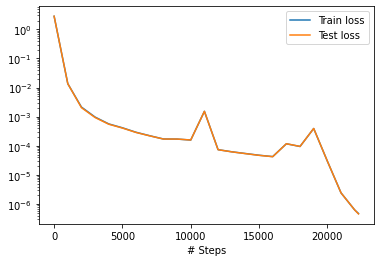

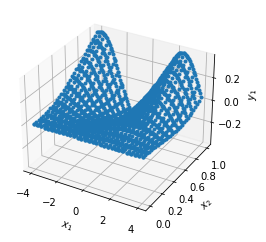

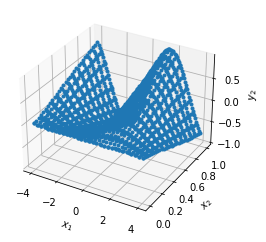

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Plotting the real values of $u$

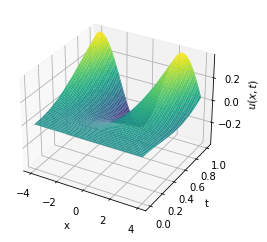

In [ ]:
x = np.linspace(-L, L, 100)
t = np.linspace(0, T, 100)
x, t = np.meshgrid(x, t)
inputs = np.column_stack((x.flatten(), t.flatten()))
true_values = exact_u(inputs).reshape(100, 100)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$u(x,t)$')
ax.plot_surface(x, t, true_values, cmap='viridis', edgecolor='none')

Plotting the predicted values of $u$

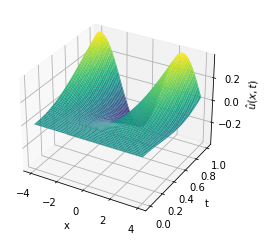

In [ ]:
predictions_u = model.predict(inputs)[:, 0]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$\hat{u}(x,t)$')
ax.plot_surface(x, t, predictions_u.reshape(100, 100), cmap='viridis', edgecolor='none')

Plotting the real values of $q$

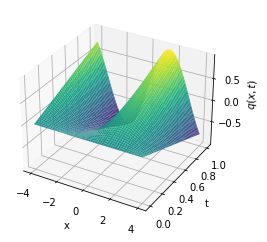

In [ ]:
true_values_q = exact_q(inputs).reshape(100, 100)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$q(x,t)$')
ax.plot_surface(x, t, true_values_q, cmap='viridis', edgecolor='none')

Plotting the predicted values of $q$

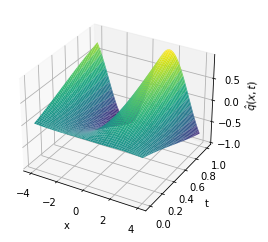

In [ ]:
predictions_q = model.predict(inputs)[:, 1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$\hat{q}(x,t)$')
ax.plot_surface(x, t, predictions_q.reshape(100, 100), cmap='viridis', edgecolor='none')

Calculating the error in the prediction

In [ ]:
error_u = (predictions_u.reshape(100, 100) - true_values)**2
error_q = (predictions_q.reshape(100, 100) - true_values_q)**2

Plotting the error in the prediction for both $u$ and $q$

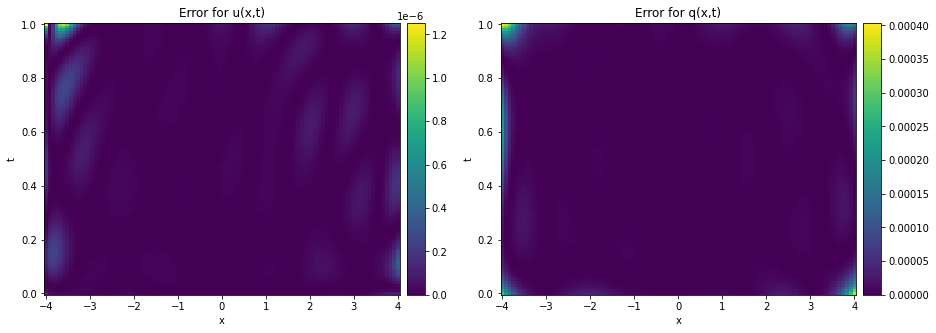

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt1 = axs[0].pcolormesh(x, t, error_u, cmap='viridis')
axs[0].set_title('Error for u(x,t)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plt1, cax=cax1, orientation='vertical');

plt2 = axs[1].pcolormesh(x, t, error_q, cmap='viridis')
axs[1].set_title('Error for q(x,t)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plt2, cax=cax2, orientation='vertical');

plt.show()